# Reproduce SimPEG(emg3d) with pyGIMLi(emg3d)

### Imports

In [1]:
%matplotlib ipympl

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import emg3d
import pygimli as pg

plt.style.use('bmh')

## Survey

In [3]:
rec_x = np.linspace(-2000, 2000, 24)
rec = emg3d.surveys.txrx_coordinates_to_dict(emg3d.RxElectricPoint, (rec_x, 0, -950, 0, 0))
src_x = np.linspace(-1900, 1900, 8)
src = emg3d.surveys.txrx_coordinates_to_dict(emg3d.TxElectricPoint, (src_x, 0, -1000, 0, 0))
frequency = 2.

survey = emg3d.Survey(src, rec, frequency, relative_error=0.01, noise_floor=1e-14)
survey

:: Survey ::

<xarray.Dataset> Size: 4kB
Dimensions:   (src: 8, rec: 24, freq: 1)
Coordinates:
  * src       (src) <U6 192B 'TxEP-1' 'TxEP-2' 'TxEP-3' ... 'TxEP-7' 'TxEP-8'
  * rec       (rec) <U7 672B 'RxEP-01' 'RxEP-02' ... 'RxEP-23' 'RxEP-24'
  * freq      (freq) <U3 12B 'f-1'
Data variables:
    observed  (src, rec, freq) complex128 3kB (nan+nanj) ... (nan+nanj)
Attributes:
    noise_floor:     1e-14
    relative_error:  0.01

## Model

In [4]:
mesh = emg3d.construct_mesh(
    center=(0, 0, 0),
    frequency=frequency,
    properties=2,
    domain=[-2000, 2000],
    center_on_edge=True,
)

mesh

TensorMesh: 64,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     40     -5,215.52      5,215.52    167.76    683.40    1.19
   y     40     -5,215.52      5,215.52    167.76    683.40    1.19
   z     40     -5,215.52      5,215.52    167.76    683.40    1.19

In [5]:
inds_air = mesh.cell_centers[:,2] > 0.
inds_seafloor = mesh.cell_centers[:,2] < -1000.

inds_hydrocarbon = (
    np.logical_and(mesh.cell_centers[:,0]>-1000, mesh.cell_centers[:,0]<1000)
    & np.logical_and(mesh.cell_centers[:,1]>-5000, mesh.cell_centers[:,1]<5000)
    & np.logical_and(mesh.cell_centers[:,2]<-1500, mesh.cell_centers[:,2]>-1700) 
)

sigma = np.ones(mesh.n_cells) * 1./0.33
sigma[inds_air] = 1./1e8
sigma[inds_seafloor] = 1./1.
bg = sigma.copy()
sigma[inds_hydrocarbon] = 1./100

model_start = emg3d.Model(mesh, bg, mapping='Conductivity')
model_true = emg3d.Model(mesh, sigma, mapping='Conductivity')

### QC

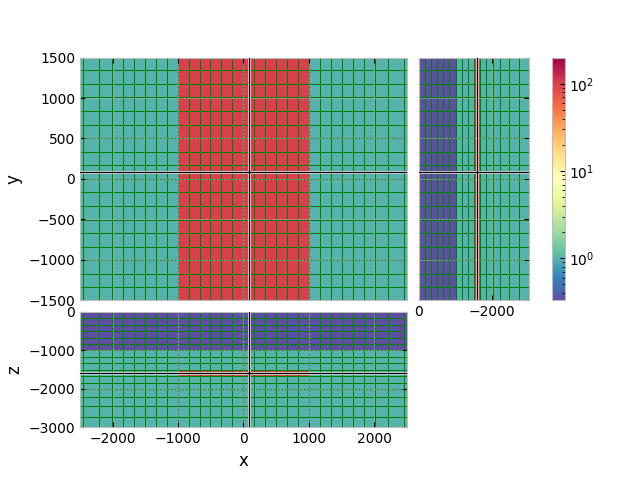

In [6]:
mesh.plot_3d_slicer(
    1/model_true.property_x,
    xlim=[-2500, 2500], ylim=[-1500, 1500],
    zlim=[-3000, 0], zslice=-1600,
    pcolor_opts={'cmap':'Spectral_r', 'linewidth': 0.5, 'edgecolor': 'g', 'norm': LogNorm(vmin=0.33, vmax=200)})

# Plot survey in figure above
fig = plt.gcf()
fig.suptitle('Resistivity model (Ohm.m) and survey layout')
axs = fig.get_children()
rec_coords = survey.receiver_coordinates()
src_coords = survey.source_coordinates()
axs[1].plot(rec_coords[0], rec_coords[1], 'bv')
axs[2].plot(rec_coords[0], rec_coords[2], 'bv')
axs[3].plot(rec_coords[2], rec_coords[1], 'bv')
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')

## Create simulation  IMPORTANT: IN SimPEG WE DID EXP(SIGMA)

In [7]:
sim = emg3d.Simulation(
        name='ReprSimPEGwithpyGIMLi',
        model=model_true,
        survey=survey,
        gridding='same',
        max_workers=6, 
        verb=False,
        receiver_interpolation='linear',
        tqdm_opts=False,
)

In [8]:
sim.compute(observed=True, min_offset=400)  # Min-offset is DIFFERENT FROM SIMPEG EXAMPLE
sim.clean('computed')

sim.model = model_start

sim.compute()
sim.survey.data['start'] = sim.survey.data.synthetic
sim.clean('computed')

## Inversion

In [9]:
# Create region markers (as many different regions as you like)
markers = np.zeros(model_start.shape, dtype=int)
markers[:, :, mesh.cell_centers_z > -1000] = 1

# Instantiate the emg3d-kernel for pyGIMLi
fop = emg3d.inversion.pygimli.Kernel(simulation=sim, markers=markers, pgthreads=1)

# Instantiate the inversion and set some inversion parameters
INV = emg3d.inversion.pygimli.Inversion(fop=fop)
#INV.inv.setCGLSTolerance(1e-3)  # is _absolute_, not _relative_
INV.inv.setMaxCGLSIter(30)
#INV.dataTrans = pg.trans.TransSymLog(sim.survey.noise_floor)

INV.fop.setRegionProperties(0, limits=(0.0001, 2), startModel=1)                  # Target
INV.fop.setRegionProperties(1, background=True)                                   # Background

In [10]:
#INV.stopAtChi1 = False
INV.run(
    #maxIter=2, # just to test
    lam=10,  # btw 1-100
    #verbose=True,
    #debug=True,
    #startModel=model_true.property_x.ravel('F'),
    #isReference=True,
)

18/07/24 - 15:51:57 - pyGIMLi - INFO - :: pyGIMLi(emg3d) START ::
18/07/24 - 15:51:57 - pyGIMLi - INFO - Created startmodel from region infos: 22400 [1.0,...,1.0]
18/07/24 - 15:52:01 - pyGIMLi - INFO - ======================================================================
                                        it        χ²   F(m)       λ        ϕᵈ        ϕᵐ    ϕ=ϕᵈ+λϕᵐ   Δϕ (%)
                                       ----------------------------------------------------------------------
18/07/24 - 15:52:01 - pyGIMLi - INFO -   0     587.7      1    10.0  185716.7       0.0  185716.7     0.00
18/07/24 - 15:55:32 - pyGIMLi - INFO -   1     247.6     45    10.0   78255.0     213.4   80389.5    56.71
18/07/24 - 15:59:14 - pyGIMLi - INFO -   2     115.9     45    10.0   36622.2     565.6   42278.5    47.41
18/07/24 - 16:03:29 - pyGIMLi - INFO -   3      36.7     45    10.0   11595.3     972.5   21320.0    49.57
18/07/24 - 16:07:29 - pyGIMLi - INFO -   4      15.6     44    10.0    4937.1   

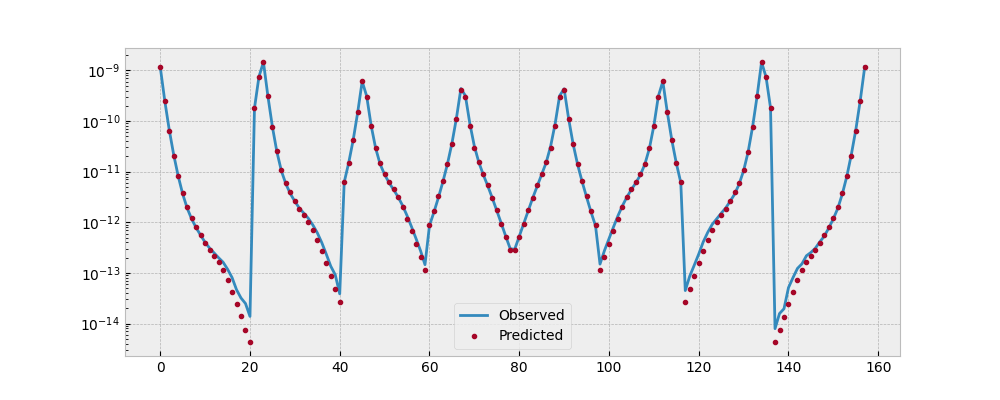

In [19]:
plt.figure(figsize=(10, 4))
data_obs = INV.fop.simulation.survey.finite_data('observed')
data_inv = INV.fop.simulation.survey.finite_data('inv')
plt.semilogy(abs(data_obs), '-', label='Observed')
plt.semilogy(abs(data_inv), '.', label='Predicted')
plt.legend()

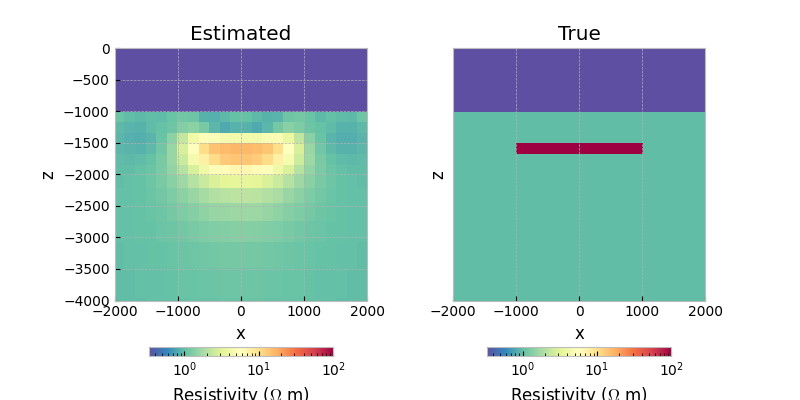

In [20]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))

sigmas = [INV.fop.simulation.model.property_x, sigma]
titles = ["Estimated", "True"]
for ii, ax in enumerate(axs):
    out = mesh.plot_slice(
        1./sigmas[ii], grid=False, normal='Y', 
        pcolor_opts={'cmap':'Spectral_r', 'norm':LogNorm(vmin=0.33, vmax=100)}, 
        ax=ax,
    )
    ax.set_aspect(1)
    ax.set_ylim(-4000, 0)
    ax.set_xlim(-2000, 2000)
    if ii == 1:
        ax.set_yticks([])
    ax.set_title(titles[ii])
    cb = plt.colorbar(out[0], ax=ax, fraction=0.03, orientation='horizontal')
    cb.set_label("Resistivity ($\Omega$ m)")

In [21]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Thu Jul 18 16:18:52 2024 CEST

                OS : Linux (Ubuntu 22.04)
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC
  12.3.0]

             numpy : 1.26.4
             scipy : 1.14.0
             numba : 0.59.1
             emg3d : 1.8.4.dev15+g52cd8b9.d20240715
           empymod : 2.3.1
            xarray : 2024.6.0
        discretize : 0.10.0
              h5py : 3.11.0
        matplotlib : 3.9.1
              tqdm : 4.66.4
           IPython : 8.26.0
           pygimli : 1.5.1+49.gf1569841
            pgcore : 1.5.0
--------------------------------------------------------------------------------